# Testing Jacobians with `IndShockModel_HANK` with 2 Sectors (Ignoring switching in the policy functions)

In [43]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn
# from HARK.utilities import jump_to_grid_1D, jump_to_grid_2D
import numba
from ConsIndShockModel_HANK import IndShockConsumerType 

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

from HARK.utilities import (
    construct_assets_grid,
    gen_tran_matrix_1D,
    gen_tran_matrix_2D,
    jump_to_grid_1D,
    jump_to_grid_2D,
    make_grid_exp_mult,
)

In [2]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [3]:

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
T_cycles = 1
cycles = 0
LivPrb = .99375
Z_ss = 0.7925
DiscFac = 0.97
UnempPrb = 0.05


In [4]:
HANK_Dict_Sec1 = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [LivPrb],                   # Survival probability
    "DiscFac": DiscFac,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01],                  # Permanent income growth factor (no perm growth)
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" :UnempPrb,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict_Sec1['TranShkMean_Func'] = [function]

In [5]:
Agent_GE_Sec1 = IndShockConsumerType(**HANK_Dict_Sec1, verbose = False)

In [6]:
Agent_GE_Sec1.compute_steady_state()

(1.2222238166427914, 0.8163455887194055)

In [7]:
CJACR, AJACR = Agent_GE_Sec1.calc_jacobian("Rfree", 300)

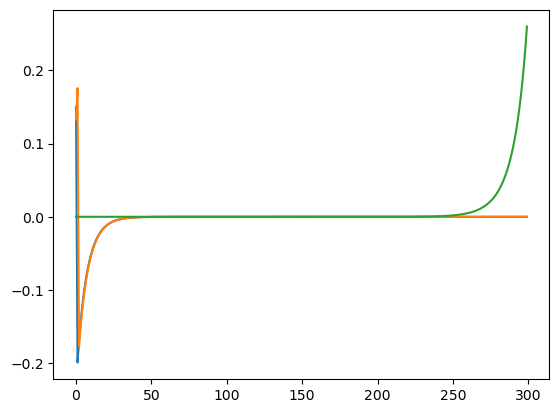

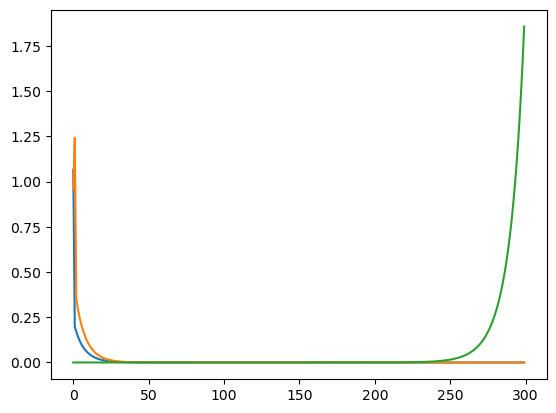

In [8]:
plt.plot(CJACR[0])
plt.plot(CJACR[1])
plt.plot(CJACR[-1])
plt.show()

plt.plot(AJACR[0])
plt.plot(AJACR[1])
plt.plot(AJACR[-1])

plt.show()

In [9]:
T = 300
shk_param = "Rfree"

In [10]:
# Set up finite Horizon dictionary
params = deepcopy(Agent_GE_Sec1.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [Agent_GE_Sec1.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [Agent_GE_Sec1.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [Agent_GE_Sec1.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [Agent_GE_Sec1.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [Agent_GE_Sec1.Rfree]
params["UnempPrb"] = params["T_cycle"] * [Agent_GE_Sec1.UnempPrb]
params["IncUnemp"] = params["T_cycle"] * [Agent_GE_Sec1.IncUnemp]

params['wage'] = params['T_cycle']*[Agent_GE_Sec1.wage[0]]
params['taxrate'] = params['T_cycle']*[Agent_GE_Sec1.taxrate[0]]
params['labor'] = params['T_cycle']*[Agent_GE_Sec1.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[Agent_GE_Sec1.TranShkMean_Func[0]]

# Create instance of a finite horizon agent
FinHorizonAgent_AUX_Sec1 = IndShockConsumerType(**params)
FinHorizonAgent_AUX_Sec1.cycles = 1  # required

# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent_AUX_Sec1.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent_AUX_Sec1.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent_AUX_Sec1.cFunc_terminal_ = deepcopy(Agent_GE_Sec1.solution[0].cFunc)

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent_AUX_Sec1.IncShkDstn = params["T_cycle"] * [Agent_GE_Sec1.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent_AUX_Sec1.del_from_time_inv(shk_param)
FinHorizonAgent_AUX_Sec1.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(Agent_GE_Sec1, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec1, shk_param)[0]]
        + [getattr(Agent_GE_Sec1, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec1, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec1, shk_param)]
        + [getattr(Agent_GE_Sec1, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec1, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent_AUX_Sec1, shk_param, peturbed_list)

# Update income process if perturbed parameter enters the income shock distribution
FinHorizonAgent_AUX_Sec1.update_income_process()

# Solve
FinHorizonAgent_AUX_Sec1.solve()

#FinHorizonAgent.Rfree = params["T_cycle"] * [Agent_GE.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent_AUX_Sec1.neutral_measure = True
FinHorizonAgent_AUX_Sec1.update_income_process()

# Calculate Transition Matrices
FinHorizonAgent_AUX_Sec1.define_distribution_grid()
FinHorizonAgent_AUX_Sec1.calc_transition_matrix()

### Sector 2

In [11]:
HANK_Dict_Sec2 = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability
    "DiscFac": 0.97,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01],                  # Permanent income growth factor (no perm growth)

    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict_Sec2['TranShkMean_Func'] = [function]

In [12]:
Agent_GE_Sec2 = IndShockConsumerType(**HANK_Dict_Sec2, verbose = False)

In [13]:
Agent_GE_Sec2.compute_steady_state()

(1.2222238166427914, 0.8163455887194055)

In [14]:
# Set up finite Horizon dictionary
params = deepcopy(Agent_GE_Sec2.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [Agent_GE_Sec2.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [Agent_GE_Sec2.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [Agent_GE_Sec2.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [Agent_GE_Sec2.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [Agent_GE_Sec2.Rfree]
params["UnempPrb"] = params["T_cycle"] * [Agent_GE_Sec2.UnempPrb]
params["IncUnemp"] = params["T_cycle"] * [Agent_GE_Sec2.IncUnemp]

params['wage'] = params['T_cycle']*[Agent_GE_Sec2.wage[0]]
params['taxrate'] = params['T_cycle']*[Agent_GE_Sec2.taxrate[0]]
params['labor'] = params['T_cycle']*[Agent_GE_Sec2.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[Agent_GE_Sec2.TranShkMean_Func[0]]

# Create instance of a finite horizon agent
FinHorizonAgent_AUX_Sec2 = IndShockConsumerType(**params)
FinHorizonAgent_AUX_Sec2.cycles = 1  # required

# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent_AUX_Sec2.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent_AUX_Sec2.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent_AUX_Sec2.cFunc_terminal_ = deepcopy(Agent_GE_Sec2.solution[0].cFunc)

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent_AUX_Sec2.IncShkDstn = params["T_cycle"] * [Agent_GE_Sec2.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent_AUX_Sec2.del_from_time_inv(shk_param)
FinHorizonAgent_AUX_Sec2.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(Agent_GE_Sec2, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec2, shk_param)[0]]
        + [getattr(Agent_GE_Sec2, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec2, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(Agent_GE_Sec2, shk_param)]
        + [getattr(Agent_GE_Sec2, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(Agent_GE_Sec2, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent_AUX_Sec2, shk_param, peturbed_list)

# Update income process if perturbed parameter enters the income shock distribution
FinHorizonAgent_AUX_Sec2.update_income_process()

# Solve
FinHorizonAgent_AUX_Sec2.solve()

#FinHorizonAgent.Rfree = params["T_cycle"] * [Agent_GE.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent_AUX_Sec2.neutral_measure = True
FinHorizonAgent_AUX_Sec2.update_income_process()

# Calculate Transition Matrices
FinHorizonAgent_AUX_Sec2.define_distribution_grid()
FinHorizonAgent_AUX_Sec2.calc_transition_matrix()

### Show Consumption Functions

In [15]:
dist_mGrid = FinHorizonAgent_AUX_Sec1.dist_mGrid

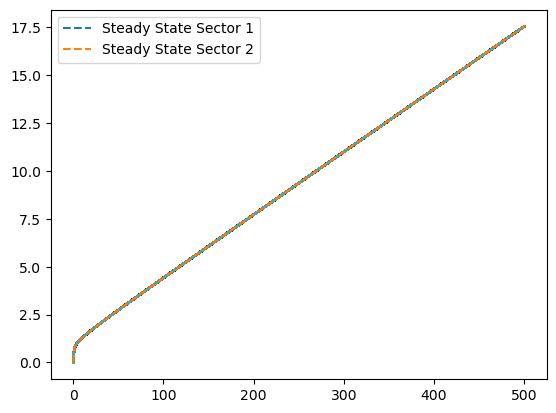

In [16]:
### Plot policy functions
for t in range(T):
    plt.plot(dist_mGrid, FinHorizonAgent_AUX_Sec1.solution[0].cFunc(dist_mGrid))
    plt.plot(dist_mGrid, FinHorizonAgent_AUX_Sec2.solution[0].cFunc(dist_mGrid))
plt.plot(dist_mGrid,  Agent_GE_Sec1.solution[0].cFunc(dist_mGrid), '--', label = "Steady State Sector 1")
plt.plot(dist_mGrid, Agent_GE_Sec2.solution[0].cFunc(dist_mGrid), '--', label = "Steady State Sector 2")
plt.legend()
plt.show()

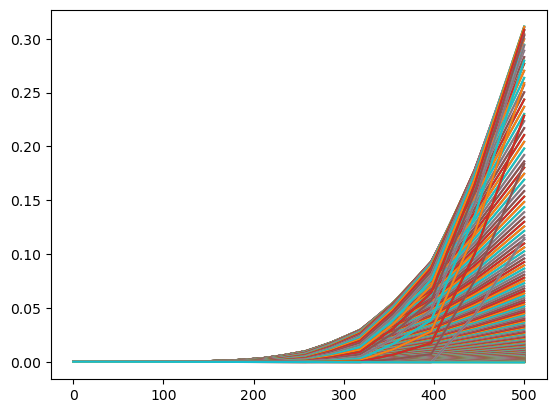

In [42]:
for t in range(T):
    plt.plot(dist_mGrid, Agent_GE_Sec1.solution[0].cFunc(dist_mGrid) - FinHorizonAgent_AUX_Sec1.solution[t].cFunc(dist_mGrid))
    plt.plot(dist_mGrid, Agent_GE_Sec2.solution[0].cFunc(dist_mGrid) - FinHorizonAgent_AUX_Sec2.solution[t].cFunc(dist_mGrid))
# plt.legend()
plt.show()

### Now use those transition matrices instead of the TwoSectorHank-Ones

In [18]:
TranMatrix_aux = []
TranMatrix_shape = (len(dist_mGrid) * 2, len(dist_mGrid) * 2)
for i in range(T):
    ### Ignore transition between Markov states and constrauct a 400 x 400 matrix
    TranMatrix_aux_array = np.zeros(TranMatrix_shape)
    TranMatrix_Sec1 = FinHorizonAgent_AUX_Sec1.tran_matrix[i]
    TranMatrix_Sec2 = FinHorizonAgent_AUX_Sec2.tran_matrix[i]
    
    # Fill the upper left corner of TranMatrix
    TranMatrix_aux_array[:len(dist_mGrid), :len(dist_mGrid)] = TranMatrix_Sec1 * MrkvArray[0, 0] # Start Markov State 1 End in Markov State 1

    # Fill the upper right corner of TranMatrix
    TranMatrix_aux_array[:len(dist_mGrid), len(dist_mGrid):] = TranMatrix_Sec1 * MrkvArray[0, 1] # Start Markov State 1 End in Markov State 2

    # Fill the lower left corner of TranMatrix
    TranMatrix_aux_array[len(dist_mGrid):, :len(dist_mGrid)] = TranMatrix_Sec2 * MrkvArray[1, 0] # Start Markov State 2 End in Markov State 1

    # Fill the lower right corner of TranMatrix
    TranMatrix_aux_array[len(dist_mGrid):, len(dist_mGrid):] = TranMatrix_Sec2 * MrkvArray[1, 1] # Start Markov State 2 End in Markov State 2

    TranMatrix_aux.append(TranMatrix_aux_array)

### Transition Matrices (Step by Step)

In [44]:
shk_dstn = FinHorizonAgent_AUX_Sec1.IncShkDstn

tran_matrix_Test = []  # List of transition matrices
bPol_Grid = []
#dist_aGrid = deepcopy(self.dist_mGrid)

#dist_mGrid_temp  = dist_aGrid*self.Rfree[k] +
for k in range(T):
    
    if type(FinHorizonAgent_AUX_Sec1.dist_pGrid) == list:
        # Permanent income grid this period
        dist_pGrid = FinHorizonAgent_AUX_Sec1.dist_pGrid[k]
    else:
        dist_pGrid = (
            FinHorizonAgent_AUX_Sec1.dist_pGrid
        )  # If here then use prespecified permanent income grid

    # Consumption policy grid in period k
    #Cnow = self.solution[k].cFunc(dist_mGrid)
    Cnow = FinHorizonAgent_AUX_Sec1.solution[k].cFunc(dist_mGrid)

    aNext = dist_mGrid - Cnow  # Asset policy grid in period k

    if type(FinHorizonAgent_AUX_Sec1.Rfree) == list:
        bNext = FinHorizonAgent_AUX_Sec1.Rfree[k] * aNext
    else:
        bNext = FinHorizonAgent_AUX_Sec1.Rfree * aNext

    # Obtain shocks and shock probabilities from income distribution this period
    shk_prbs = shk_dstn[k].pmv  # Probability of shocks this period
    # Transitory shocks this period
    tran_shks = shk_dstn[k].atoms[1]
    # Permanent shocks this period
    perm_shks = shk_dstn[k].atoms[0]
    # Update probability of staying alive this period
    LivPrb = FinHorizonAgent_AUX_Sec1.LivPrb[k]

    if len(dist_pGrid) == 1:
        # New borns have this distribution (assumes start with no assets and permanent income=1)
        NewBornDist = jump_to_grid_1D(
            np.zeros_like(tran_shks),
            shk_prbs,
            dist_mGrid,)
        # Compute Transition Matrix given shocks and grids.
        TranMatrix_M = gen_tran_matrix_1D(
            dist_mGrid,
            bNext,
            shk_prbs,
            perm_shks,
            tran_shks,
            LivPrb,
            NewBornDist,
        )
        tran_matrix_Test.append(TranMatrix_M)
        bPol_Grid.append(bNext)


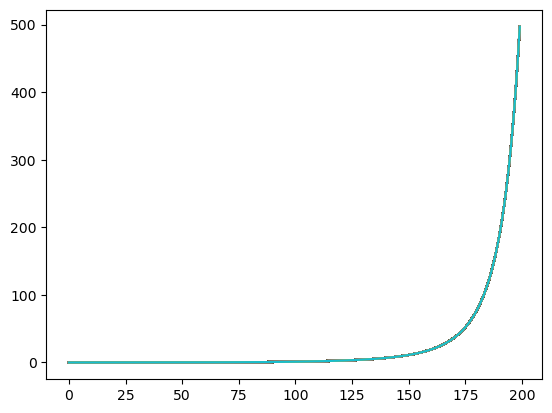

In [45]:
for t in range(T):
    plt.plot(bPol_Grid[t])

In [46]:
NewBornDist

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

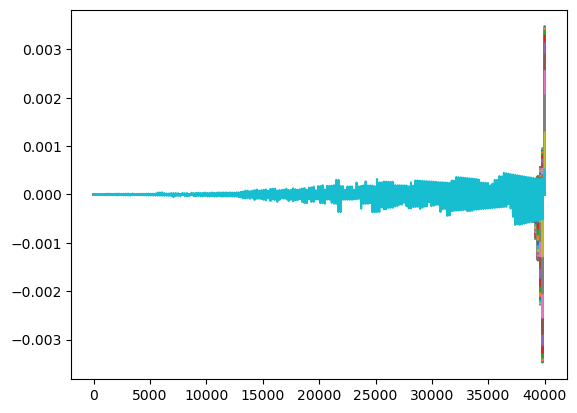

In [47]:
for i in range(T):
    plt.plot(tran_matrix_Test[i].flatten() - Agent_GE_Sec1.tran_matrix.flatten())
plt.show()

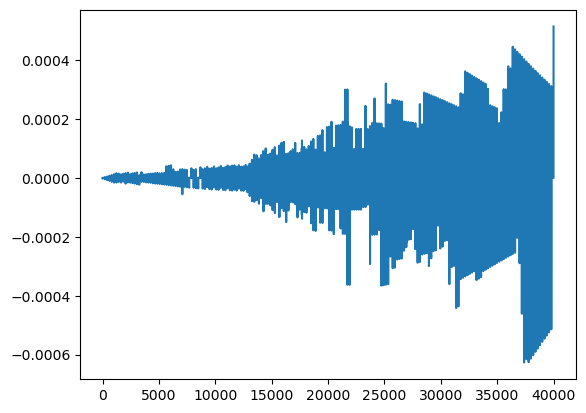

In [60]:
plt.plot(tran_matrix_Test[-1].flatten() - Agent_GE_Sec1.tran_matrix.flatten())
plt.show()

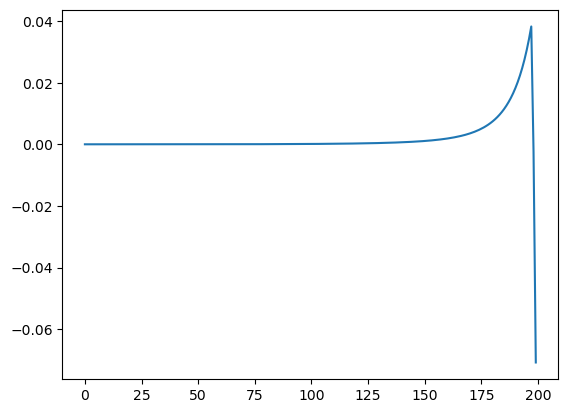

In [62]:
plt.plot(bPol_Grid[-1] - bPol_Grid[-2])

In [70]:
TranMatrix_M

array([[0.0559375 , 0.04493013, 0.03363917, ..., 0.00625   , 0.00625   ,
        0.00625   ],
       [0.        , 0.01100737, 0.02229833, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.57874914, 0.23652229,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17304603, 0.58764833,
        0.23124041],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16957938,
        0.76250959]])

In [ ]:
stop

In [48]:
##########
# STEP 1 # of fake news algorithm, As in the paper for Curly Y and Curly D. Here the policies are over assets and consumption so we denote them as curly C and curly D.
##########
# Policy Functions are now arrays with dimension (Nr of States x len(dist_mGrid)). We need to stack them to get a vector.
FinHorizonAgent_AUX_Sec1.aPol_Grid
a_ss = np.concatenate([Agent_GE_Sec1.aPol_Grid, Agent_GE_Sec2.aPol_Grid])  # steady state Asset Policy
c_ss = np.concatenate([Agent_GE_Sec1.cPol_Grid, Agent_GE_Sec2.cPol_Grid])  # steady state Consumption Policy

# Steady State Transition Matrix
tranmat_ss = np.zeros(TranMatrix_shape)
TranMatrix_Sec1 = Agent_GE_Sec1.tran_matrix
TranMatrix_Sec2 = Agent_GE_Sec2.tran_matrix

# Fill the upper left corner of TranMatrix
tranmat_ss[:len(dist_mGrid), :len(dist_mGrid)] = TranMatrix_Sec1 * MrkvArray[0, 0] # Start Markov State 1 End in Markov State 1

# Fill the upper right corner of TranMatrix
tranmat_ss[:len(dist_mGrid), len(dist_mGrid):] = TranMatrix_Sec1 * MrkvArray[0, 1] # Start Markov State 1 End in Markov State 2

# Fill the lower left corner of TranMatrix
tranmat_ss[len(dist_mGrid):, :len(dist_mGrid)] = TranMatrix_Sec2 * MrkvArray[1, 0] # Start Markov State 2 End in Markov State 1

# Fill the lower right corner of TranMatrix
tranmat_ss[len(dist_mGrid):, len(dist_mGrid):] = TranMatrix_Sec2 * MrkvArray[1, 1] # Start Markov State 2 End in Markov State 2


# List of asset policies grids where households expect the shock to occur in the second to last Period
## Need to concatenate for each T
a_t = []
for t in range(T):
    a_t.append(np.concatenate([FinHorizonAgent_AUX_Sec1.aPol_Grid[t], FinHorizonAgent_AUX_Sec2.aPol_Grid[t]]))
# add steady state assets to list as it does not get appended in calc_transition_matrix method
a_t.append(a_ss)

# List of consumption policies grids where households expect the shock to occur in the second to last Period
# c_t = [np.concatenate(FinHorizonAgent.cPol_Grid)]
c_t = []
for t in range(T):
    c_t.append(np.concatenate([FinHorizonAgent_AUX_Sec1.cPol_Grid[t], FinHorizonAgent_AUX_Sec2.cPol_Grid[t]]))
# add steady state consumption to list as it does not get appended in calc_transition_matrix method
c_t.append(c_ss)

da0_s = []  # Deviation of asset policy from steady state policy
dc0_s = []  # Deviation of Consumption policy from steady state policy
for i in range(T):
    da0_s.append(a_t[T - i] - a_ss)
    dc0_s.append(c_t[T - i] - c_ss)

da0_s = np.array(da0_s)
dc0_s = np.array(dc0_s)

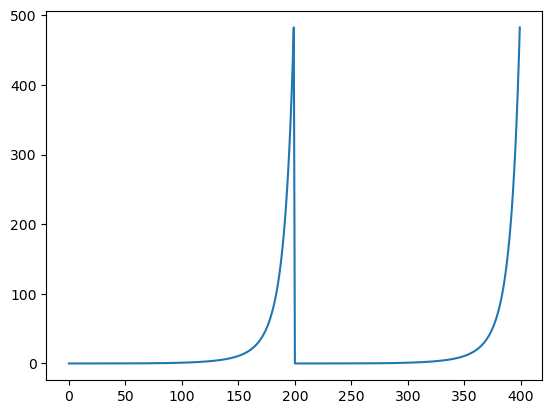

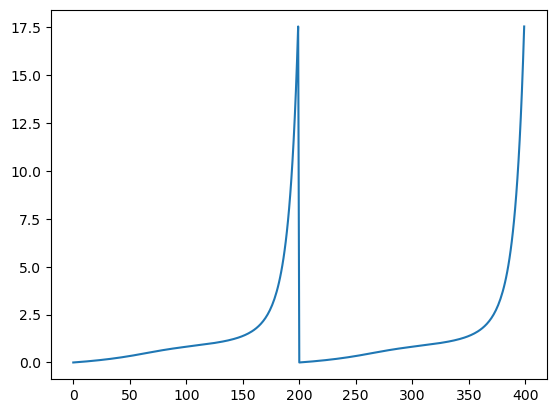

In [49]:
plt.plot(a_ss)
plt.show()
plt.plot(c_ss)

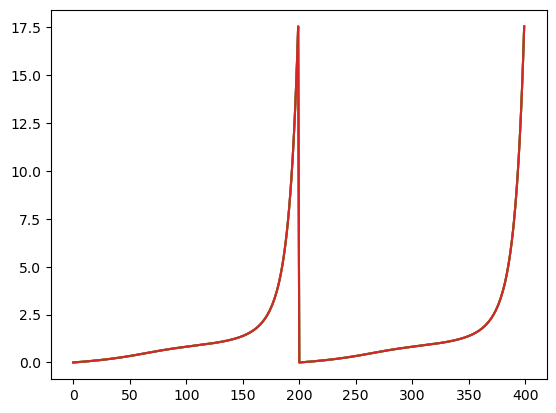

In [50]:
plt.plot(c_t[0])
plt.plot(c_t[1])
plt.plot(c_t[10])
plt.plot(c_t[50])

## Ergodic Distribution is different! Needed to half it

In [51]:
# Steady state distribution of market resources (permanent income weighted distribution)
D_ss = np.concatenate([Agent_GE_Sec1.vec_erg_dstn.T[0], Agent_GE_Sec2.vec_erg_dstn.T[0]]) /2
dA0_s = []
dC0_s = []
for i in range(T):
    dA0_s.append(np.dot(da0_s[i], D_ss))
    dC0_s.append(np.dot(dc0_s[i], D_ss))

dA0_s = np.array(dA0_s)

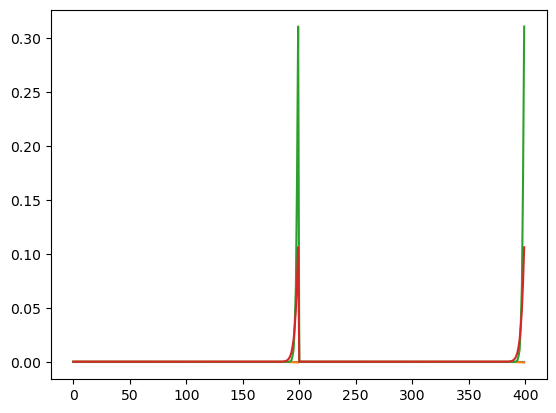

In [52]:
plt.plot(da0_s[0])
plt.plot(da0_s[1])
plt.plot(da0_s[10])
plt.plot(da0_s[50])

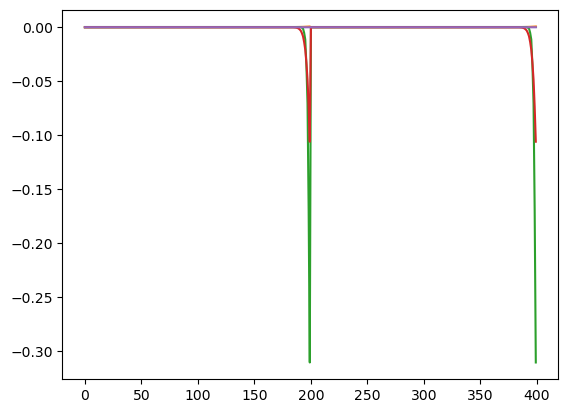

In [53]:
plt.plot(dc0_s[0])
plt.plot(dc0_s[1])
plt.plot(dc0_s[10])
plt.plot(dc0_s[50])
plt.plot(dc0_s[-1])

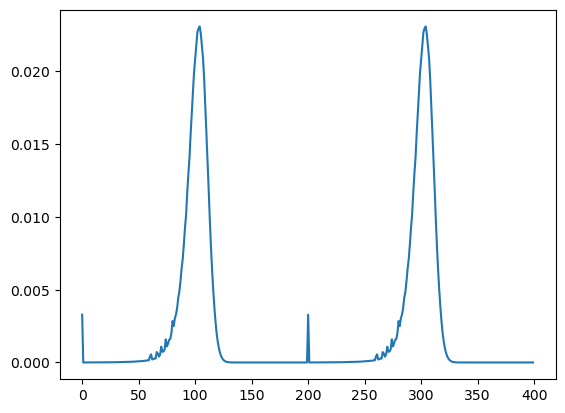

In [54]:
plt.plot(D_ss)

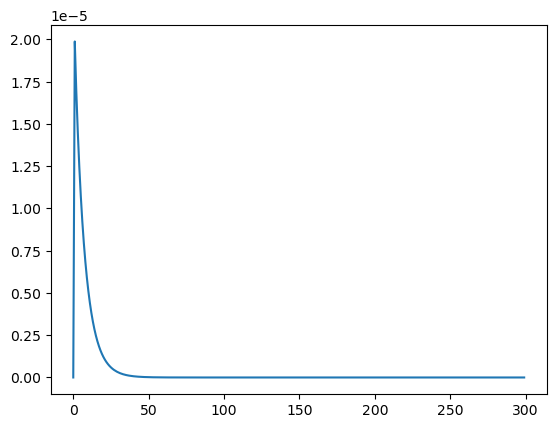

In [55]:
plt.plot(dA0_s)

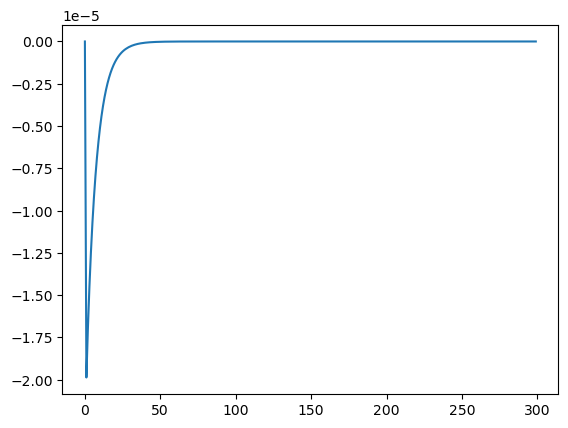

In [56]:
plt.plot(dC0_s)

In [57]:
# This is equivalent to the curly Y scalar detailed in the first step of the algorithm
A_curl_s = dA0_s / dx

dC0_s = np.array(dC0_s)
C_curl_s = dC0_s / dx

# List of computed transition matrices for each period
tranmat_t =  TranMatrix_aux
tranmat_t.append(tranmat_ss)
# List of change in transition matrix relative to the steady state transition matrix
dlambda0_s = []
for i in range(T):
    dlambda0_s.append(tranmat_t[T  -   i] - tranmat_ss)

dlambda0_s = np.array(dlambda0_s)



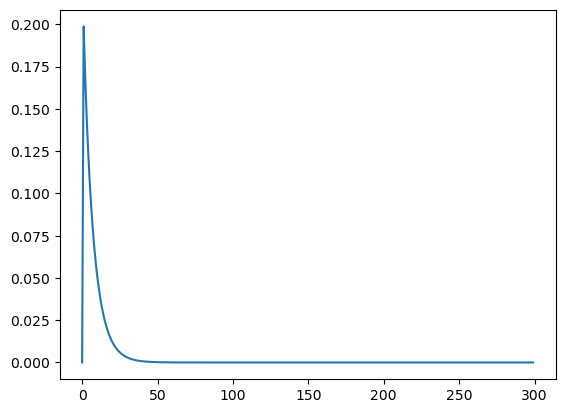

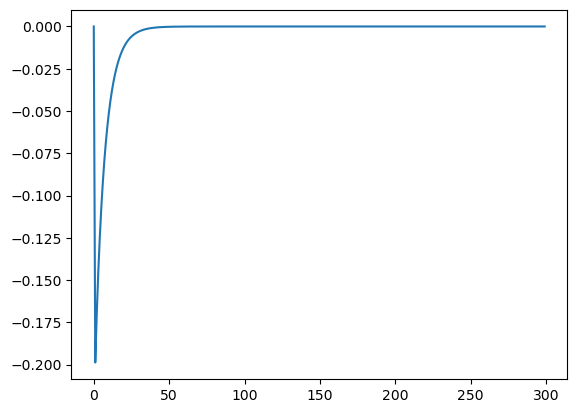

In [58]:
plt.plot(A_curl_s)
plt.show()
plt.plot(C_curl_s)
plt.show()

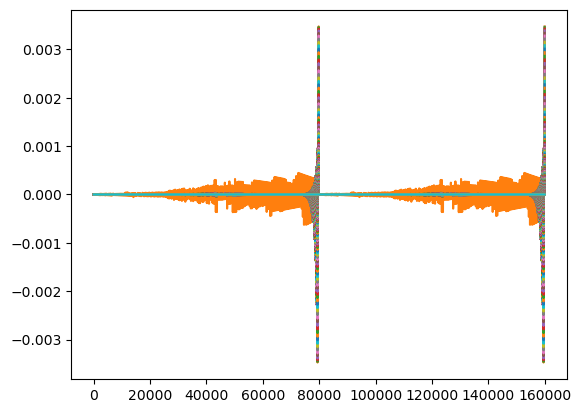

In [59]:
for i in range(T):
    plt.plot(dlambda0_s[i].flatten())
plt.show()

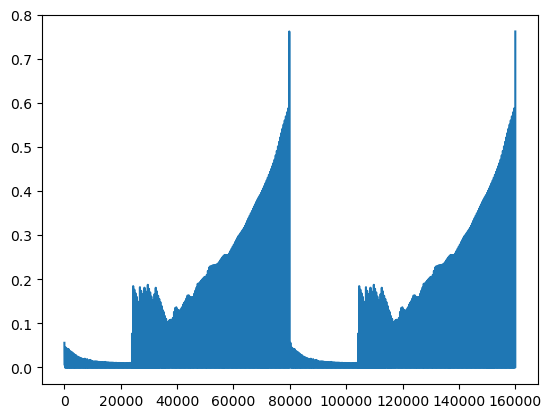

In [33]:
plt.plot(tranmat_ss.flatten())

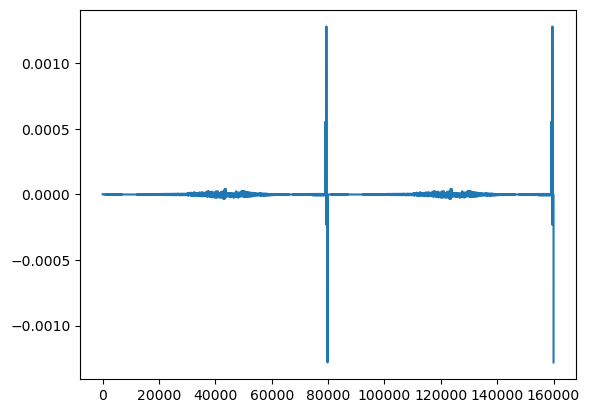

In [40]:
plt.plot(tranmat_ss.flatten() - tranmat_t[-3].flatten())

In [31]:
stop

NameError: name 'stop' is not defined

In [ ]:
tranmat_ss

array([[0.0559375 , 0.04493078, 0.03364049, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01100672, 0.02229701, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.57852577, 0.23704715,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17273394, 0.5874286 ,
        0.23175484],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16927425,
        0.76199516]])

In [ ]:
tranmat_t[1]

array([[0.0559375 , 0.04493078, 0.03364049, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01100672, 0.02229701, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.57852583, 0.23704701,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17273403, 0.58742866,
        0.2317547 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16927434,
        0.7619953 ]])

In [ ]:
dlambda0_s[1]

array([[ 0.00000000e+00, -6.55160108e-07, -1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.55160108e-07,  1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.23368626e-04, -5.24863620e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.12083855e-04,  2.19733049e-04, -5.14433117e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.05130570e-04,  5.14433117e-04]])

In [ ]:
np.max(dlambda0_s)

0.003472110921054594

In [ ]:
dD0_s = []
for i in range(T):
    dD0_s.append(np.dot(dlambda0_s[i], D_ss))

dD0_s = np.array(dD0_s)
D_curl_s = dD0_s / dx  # Curly D in the sequence space jacobian

In [ ]:
dlambda0_s[1]

array([[ 0.00000000e+00, -6.55160108e-07, -1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.55160108e-07,  1.32814875e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.23368626e-04, -5.24863620e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.12083855e-04,  2.19733049e-04, -5.14433117e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.05130570e-04,  5.14433117e-04]])

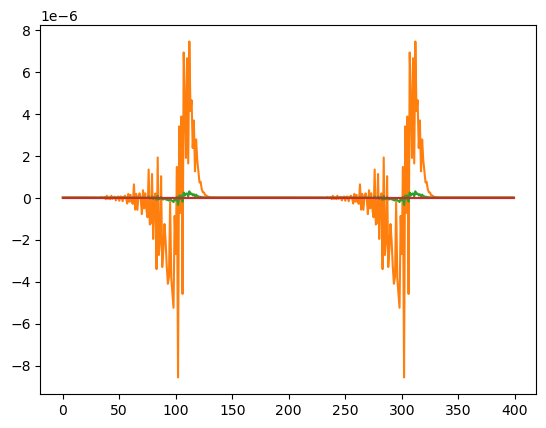

In [ ]:
plt.plot(dD0_s[0])
plt.plot(dD0_s[1])
plt.plot(dD0_s[10])
plt.plot(dD0_s[-1])

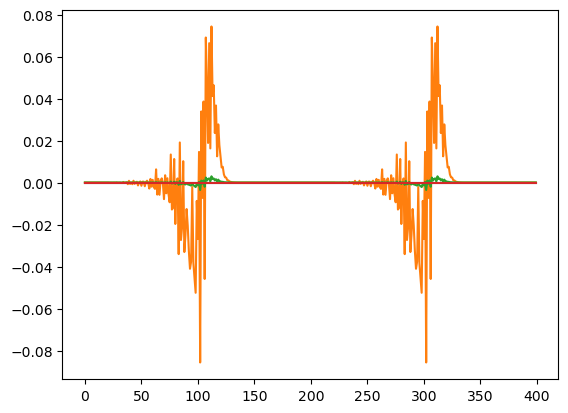

In [ ]:
plt.plot(D_curl_s[0])
plt.plot(D_curl_s[1])
plt.plot(D_curl_s[10])
plt.plot(D_curl_s[-1])

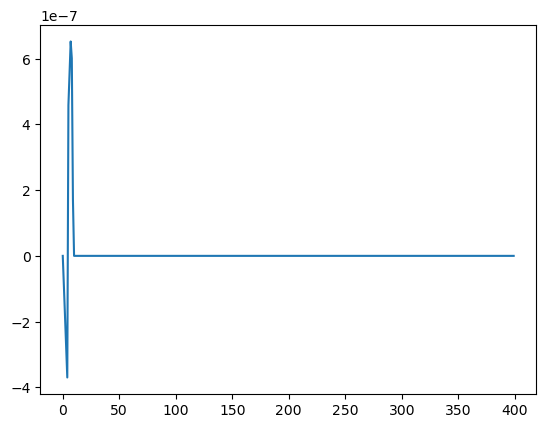

In [ ]:
plt.plot(dlambda0_s[2][1])

In [ ]:
np.max(dlambda0_s)

0.003472110921054594

In [ ]:
########
# STEP2 # of fake news algorithm
########

# Expectation Vectors
exp_vecs_a = []
exp_vecs_c = []

# First expectation vector is the steady state policy
exp_vec_a = a_ss
exp_vec_c = c_ss
for i in range(T):
    exp_vecs_a.append(exp_vec_a)
    exp_vec_a = np.dot(tranmat_ss.T, exp_vec_a)

    exp_vecs_c.append(exp_vec_c)
    exp_vec_c = np.dot(tranmat_ss.T, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(tranmat_ss, exp_vec_a)

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(tranmat_ss, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(exp_vec_a, tranmat_ss )

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(exp_vec_c, tranmat_ss)

# Turn expectation vectors into arrays
exp_vecs_a = np.array(exp_vecs_a)
exp_vecs_c = np.array(exp_vecs_c)


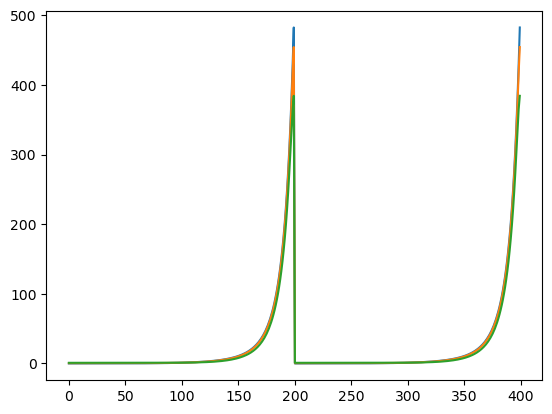

In [ ]:
plt.plot(exp_vecs_a[0])
plt.plot(exp_vecs_a[2])
plt.plot(exp_vecs_a[10])

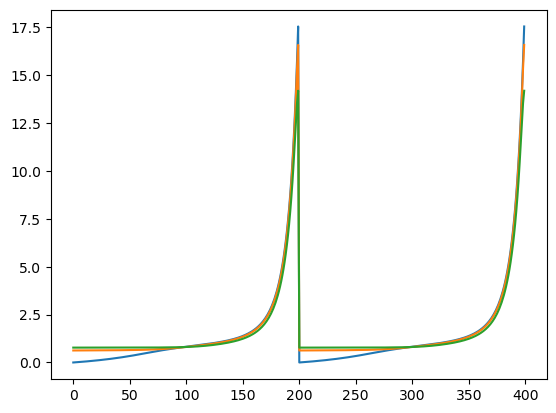

In [ ]:
plt.plot(exp_vecs_c[0])
plt.plot(exp_vecs_c[2])
plt.plot(exp_vecs_c[10])

In [ ]:
#########
# STEP3 # of the algorithm. In particular equation 26 of the published paper.
#########
# Fake news matrices
Curl_F_A = np.zeros((T, T))  # Fake news matrix for assets
Curl_F_C = np.zeros((T, T))  # Fake news matrix for consumption

# First row of Fake News Matrix
Curl_F_A[0] = A_curl_s
Curl_F_C[0] = C_curl_s


for i in range(T - 1):
    for j in range(T):
        Curl_F_A[i + 1][j] = np.dot(exp_vecs_a[i], D_curl_s[j])
        Curl_F_C[i + 1][j] = np.dot(exp_vecs_c[i], D_curl_s[j])


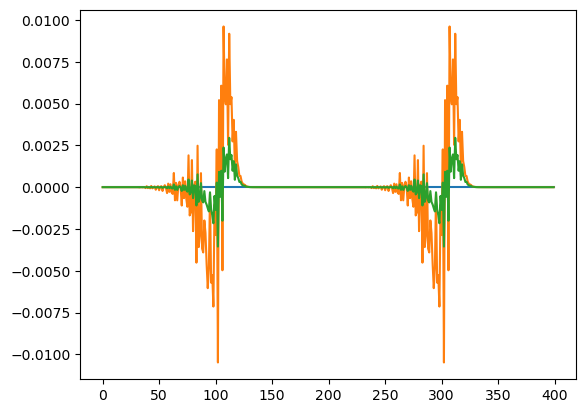

In [ ]:
plt.plot(D_curl_s[0])
plt.plot(D_curl_s[2])
plt.plot(D_curl_s[10])

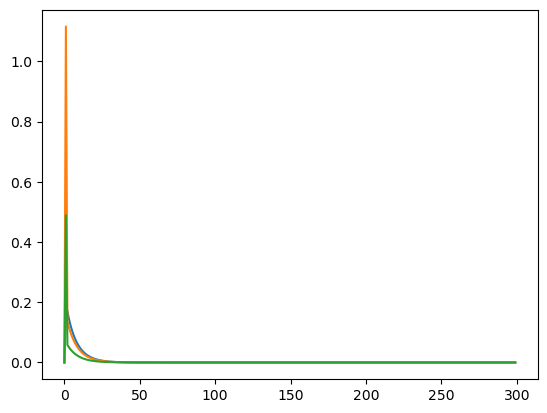

In [ ]:
plt.plot(Curl_F_A[0])
plt.plot(Curl_F_A[2])
plt.plot(Curl_F_A[10])

In [ ]:
########
# STEP4 #  of the algorithm
########

# Function to compute jacobian matrix from fake news matrix
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

J_A = J_from_F(Curl_F_A)
J_C = J_from_F(Curl_F_C)


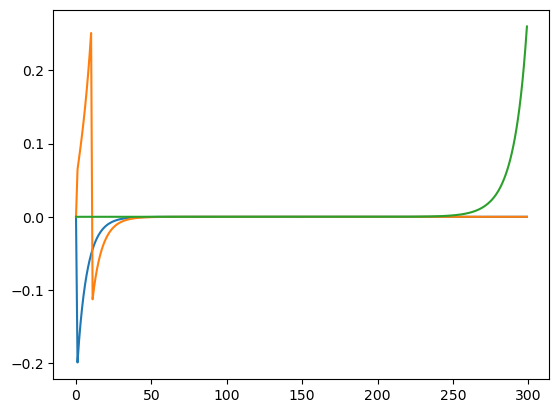

In [ ]:
plt.plot(J_C[0])
plt.plot(J_C[10])
plt.plot(J_C[-1])

In [ ]:
########
# Additional step due to compute Zeroth Column of the Jacobian
########   
    
params = deepcopy(self.__dict__["parameters"])
params["T_cycle"] = 2 # Dimension of Jacobian Matrix

params["LivPrb"] = params["T_cycle"] * [self.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [self.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [self.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [self.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [self.Rfree]
params["UnempPrb"] = params["T_cycle"] * [self.UnempPrb]
params["IncUnemp"] = params["T_cycle"] * [self.IncUnemp]
params['wage'] = params['T_cycle']*[self.wage[0]]
params['taxrate'] = params['T_cycle']*[self.taxrate[0]]
params['labor'] = params['T_cycle']*[self.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[self.TranShkMean_Func[0]]
params['IncShkDstn'] = params['T_cycle']* [self.IncShkDstn[0]]
params['cFunc_terminal_'] = deepcopy(self.solution[0].cFunc)

if shk_param == 'DiscFac':
    
    params['DiscFac'] = params['T_cycle']*[self.DiscFac]

# Create instance of a finite horizon agent for calculation of zeroth
ZerothColAgent = IndShockConsumerType(**params)
ZerothColAgent.cycles = 1  # required

# If parameter is in time invariant list then add it to time vary list
ZerothColAgent.del_from_time_inv(shk_param)
ZerothColAgent.add_to_time_vary(shk_param)

if type(getattr(self, shk_param)) == list:
    ZerothColAgent.shk_param = params['T_cycle'] * [getattr(self, shk_param)[0]]
else:
    ZerothColAgent.shk_param = params['T_cycle'] * [getattr(self, shk_param)]

# Update income process if perturbed parameter enters the income shock distribution
ZerothColAgent.update_income_process()

# Solve
ZerothColAgent.solve()

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(self, shk_param)) == list:
    peturbed_list = (
            [getattr(self, shk_param)[0] + dx]
        + (params["T_cycle"]  - 1) * [getattr(self, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
            [getattr(self, shk_param) + dx]
        + (params["T_cycle"]  - 1) * [getattr(self, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(ZerothColAgent, shk_param, peturbed_list) # Set attribute to agent

# Use Harmenberg Neutral Measure
ZerothColAgent.neutral_measure = True
ZerothColAgent.update_income_process()

# Calculate Transition Matrices
ZerothColAgent.define_distribution_grid()
ZerothColAgent.calc_transition_matrix()

tranmat_t_zeroth_col = ZerothColAgent.tran_matrix
dstn_t_zeroth_col = self.vec_erg_dstn.T[0]

C_t_no_sim = np.zeros(T)
A_t_no_sim = np.zeros(T)

for i in range(T):
    if i ==0:
        dstn_t_zeroth_col = np.dot(tranmat_t_zeroth_col[i],dstn_t_zeroth_col)
    else:
        dstn_t_zeroth_col = np.dot(tranmat_ss,dstn_t_zeroth_col)
        
    C_t_no_sim[i] =  np.dot(self.cPol_Grid ,dstn_t_zeroth_col) 
    A_t_no_sim[i] =  np.dot( self.aPol_Grid ,dstn_t_zeroth_col) 

J_A.T[0] = (A_t_no_sim - self.A_ss)/dx
J_C.T[0] = (C_t_no_sim - self.C_ss)/dx
